In [1]:
%pip install pyaogmaneo numpy matplotlib scikit-learn

Note: you may need to restart the kernel to use updated packages.


In [2]:
# Standard imports
import numpy as np
import pyaogmaneo as neo
import pickle
import time
from pathlib import Path
from collections import Counter
import matplotlib.pyplot as plt

# Configure PyAOgmaNeo
neo.set_num_threads(4)  # Adjust based on CPU

# Model configuration
MODEL_CONFIG = {
    'hidden_size': (5, 5, 64),    # Same as char_test.py
    'up_radius': 2,               # Prediction radius
    'down_radius': 2,             # Update radius
    'dendrites': 8                # Dendrites per cell
}

# Training parameters
TRAIN_CONFIG = {
    'max_words': 1000000,         # Maximum words to train on
    'num_epochs': 15,             # Number of epochs
    'save_interval': 10           # Save every N epochs
}

# File paths
PATHS = {
    'text': Path('ts_snippet.txt'),
    'model': Path('word2.ohr'),
    'vocab': Path('word_vocab2.pkl')
}

print("Configuration loaded.")


Configuration loaded.


Loading text from ts_snippet.txt...

Dataset Statistics:
Total words: 4566
Unique words: 1851
Vocabulary coverage: 40.54%


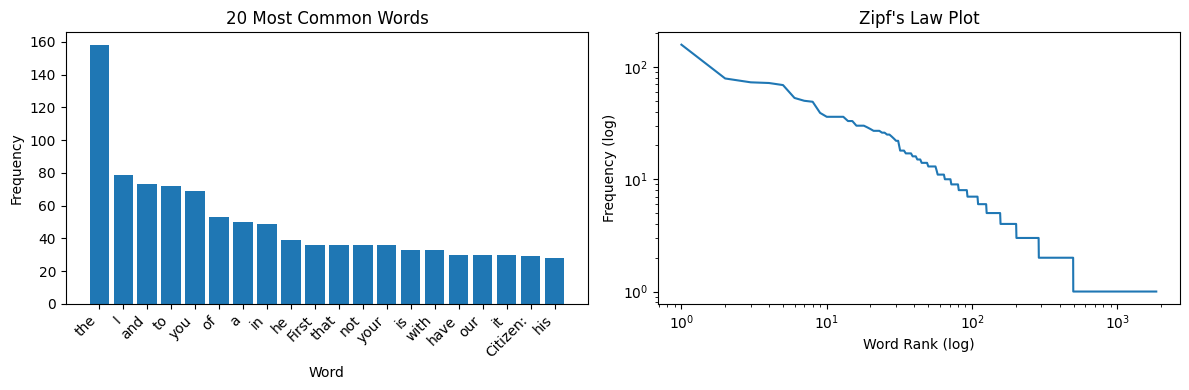

In [3]:
# Load and preprocess text
print(f"Loading text from {PATHS['text']}...")
with open(PATHS['text'], 'r') as f:
    text = f.read()

# Split into words
words = text.split()  # Simple whitespace splitting
word_counts = Counter(words)

# Build vocabulary (same approach as char_test.py)
word_set = {}        # word -> index mapping
word_set_rev = {}    # index -> word mapping
num_words = 0

for word in words:
    if word not in word_set:
        word_set[word] = num_words
        word_set_rev[num_words] = word
        num_words += 1

# Print statistics
print("\nDataset Statistics:")
print(f"Total words: {len(words)}")
print(f"Unique words: {num_words}")
print(f"Vocabulary coverage: {num_words/len(words)*100:.2f}%")

# Visualize word frequency distribution
plt.figure(figsize=(12, 4))

# Most common words
plt.subplot(1, 2, 1)
most_common = word_counts.most_common(20)
plt.bar(range(len(most_common)), [count for _, count in most_common])
plt.xticks(range(len(most_common)), [word for word, _ in most_common], rotation=45, ha='right')
plt.title('20 Most Common Words')
plt.xlabel('Word')
plt.ylabel('Frequency')

# Zipf's law plot
plt.subplot(1, 2, 2)
word_freqs = sorted(word_counts.values(), reverse=True)
plt.loglog(range(1, len(word_freqs) + 1), word_freqs)
plt.title("Zipf's Law Plot")
plt.xlabel('Word Rank (log)')
plt.ylabel('Frequency (log)')

plt.tight_layout()
plt.show()


In [4]:
# Create model (following char_test.py structure)
lds = []

# Create layer descriptor
ld = neo.LayerDesc()
ld.hidden_size = MODEL_CONFIG['hidden_size']
ld.up_radius = MODEL_CONFIG['up_radius']
ld.down_radius = MODEL_CONFIG['down_radius']
lds.append(ld)

# Create hierarchy
h = neo.Hierarchy([
    neo.IODesc(
        (1, 1, num_words),  # Input/output dimensions
        io_type=neo.prediction,
        num_dendrites_per_cell=MODEL_CONFIG['dendrites'],
        up_radius=0,
        down_radius=MODEL_CONFIG['down_radius']
    )
], lds)

print("Model created.")


Model created.


In [5]:
# Training loop (following char_test.py exactly)
print("\nStarting training...")

for epoch in range(TRAIN_CONFIG['num_epochs']):
    print(f"\nEpoch {epoch}")
    
    # Initialize counters
    words_train = 0
    correct = 0
    
    # Optional: clear state at start of epoch (commented out like in char_test.py)
    #h.clear_state()
    
    start = time.time()
    
    # Process each word (same logic as char_test.py)
    for i in range(len(words)):
        # Get current word index
        word = words[i]
        word_idx = word_set[word]
        
        # Check if prediction matches current word
        # This happens BEFORE stepping, just like in char_test.py
        if word_idx == h.get_prediction_cis(0)[0]:
            correct += 1
        
        # Step the model with current word
        h.step([[int(word_idx)]], True)
        
        # Update counters
        words_train += 1
        
        # Check training limit
        if words_train >= TRAIN_CONFIG['max_words']:
            break
        
        # Progress update
        if i % 1000 == 999:
            accuracy = correct / (i + 1)
            print(f"Words: {i+1}, Accuracy: {accuracy:.4f}", end='\r')
    
    # Calculate epoch metrics
    end = time.time()
    words_per_s = words_train / max(0.0001, end - start)
    
    # Print epoch results (same format as char_test.py)
    print(f"\nEpoch {epoch} had {correct / words_train:.4f} correct "
          f"({words_train - correct} mistakes). Speed: {words_per_s:.1f} words/s")
    
    # Save periodically
    if (epoch + 1) % TRAIN_CONFIG['save_interval'] == 0:
        h.save_to_file(str(PATHS['model']))
        with open(PATHS['vocab'], 'wb') as f:
            pickle.dump((word_set, word_set_rev), f)

# Save final model
h.save_to_file(str(PATHS['model']))
with open(PATHS['vocab'], 'wb') as f:
    pickle.dump((word_set, word_set_rev), f)



Starting training...

Epoch 0
Words: 4000, Accuracy: 0.0415
Epoch 0 had 0.0390 correct (4388 mistakes). Speed: 314.7 words/s

Epoch 1
Words: 4000, Accuracy: 0.0988
Epoch 1 had 0.1005 correct (4107 mistakes). Speed: 316.2 words/s

Epoch 2
Words: 4000, Accuracy: 0.2918
Epoch 2 had 0.2961 correct (3214 mistakes). Speed: 299.1 words/s

Epoch 3
Words: 4000, Accuracy: 0.7913
Epoch 3 had 0.8044 correct (893 mistakes). Speed: 313.8 words/s

Epoch 4
Words: 4000, Accuracy: 0.9722
Epoch 4 had 0.9755 correct (112 mistakes). Speed: 305.0 words/s

Epoch 5
Words: 4000, Accuracy: 0.9928
Epoch 5 had 0.9936 correct (29 mistakes). Speed: 310.7 words/s

Epoch 6
Words: 4000, Accuracy: 0.9990
Epoch 6 had 0.9989 correct (5 mistakes). Speed: 310.0 words/s

Epoch 7
Words: 4000, Accuracy: 0.9985
Epoch 7 had 0.9987 correct (6 mistakes). Speed: 317.3 words/s

Epoch 8
Words: 4000, Accuracy: 0.9985
Epoch 8 had 0.9980 correct (9 mistakes). Speed: 307.1 words/s

Epoch 9
Words: 4000, Accuracy: 0.9998
Epoch 9 had 0.99

In [6]:
# Test prediction function
def test_predictions(model, test_sequence, word_set, word_set_rev, max_steps=20):
    """Test model predictions on a sequence.
    
    Shows step-by-step:
    1. Current word being processed
    2. Model's prediction (made before seeing the word)
    3. Whether prediction was correct
    """
    print("\nTesting predictions:")
    print("Input sequence:", " ".join(test_sequence[:max_steps]))
    
    # Clear model state
    model.clear_state()
    
    correct = 0
    for i, word in enumerate(test_sequence[:max_steps]):
        # Get current prediction (before seeing word)
        pred_idx = model.get_prediction_cis(0)[0]
        pred_word = word_set_rev[pred_idx]
        
        # Get current word
        word_idx = word_set[word]
        
        # Check prediction
        is_correct = (word_idx == pred_idx)
        if is_correct:
            correct += 1
        
        # Print step info
        print(f"\nStep {i+1}:")
        print(f"Current word: '{word}'")
        print(f"Model predicted: '{pred_word}'")
        print(f"Correct: {is_correct}")
        
        # Step model with current word
        model.step([[int(word_idx)]], True)
    
    # Print summary
    print(f"\nOverall accuracy: {correct/max_steps:.4f} ({correct}/{max_steps})")

# Test on different parts of text
print("\nTesting on start of text:")
test_predictions(h, words[:20], word_set, word_set_rev)

print("\nTesting on middle of text:")
mid_start = len(words)//2
test_predictions(h, words[mid_start:mid_start+20], word_set, word_set_rev)

print("\nTesting on end of text:")
test_predictions(h, words[-20:], word_set, word_set_rev)



Testing on start of text:

Testing predictions:
Input sequence: First Citizen: Before we proceed any further, hear me speak. All: Speak, speak. First Citizen: You are all resolved rather

Step 1:
Current word: 'First'
Model predicted: 'First'
Correct: True

Step 2:
Current word: 'Citizen:'
Model predicted: 'Citizen:'
Correct: True

Step 3:
Current word: 'Before'
Model predicted: 'You'
Correct: False

Step 4:
Current word: 'we'
Model predicted: 'you'
Correct: False

Step 5:
Current word: 'proceed'
Model predicted: 'proceed'
Correct: True

Step 6:
Current word: 'any'
Model predicted: 'any'
Correct: True

Step 7:
Current word: 'further,'
Model predicted: 'further,'
Correct: True

Step 8:
Current word: 'hear'
Model predicted: 'hear'
Correct: True

Step 9:
Current word: 'me'
Model predicted: 'me'
Correct: True

Step 10:
Current word: 'speak.'
Model predicted: 'speak.'
Correct: True

Step 11:
Current word: 'All:'
Model predicted: 'All:'
Correct: True

Step 12:
Current word: 'Speak,'
Model p

In [ ]:
# Autoregressive text generation
# Feed initial words to the model, then generate the next 15 words

# Start with a clean state
h.clear_state()

# Input some words to establish context
input_words = ["First", "Citizen:", "Before", "we"]

print("Input words:", " ".join(input_words))

# Feed the input words
for word in input_words:
    if word in word_set:
        word_idx = word_set[word]
        h.step([[int(word_idx)]], True)

# Generate next 15 words autoregressively
generated_words = []
print("\nGenerating next 15 words:")

for i in range(15):
    # Get prediction
    pred_idx = h.get_prediction_cis(0)[0]
    pred_word = word_set_rev[pred_idx]
    generated_words.append(pred_word)
    
    # Feed the prediction back to the model for next prediction
    h.step([[int(pred_idx)]], True)

# Display the complete generated sequence
print("\nComplete generated text:")
print(" ".join(input_words + generated_words))


Input words: First Citizen: Before we

Generating next 15 words:

Complete generated text:
First Citizen: Before we proceed any further, hear me speak. All: Speak, speak. First Citizen: You are all resolved
